In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Load Data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),transforms.RandomResizedCrop(224,antialias=True),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Select Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Create Model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer_one = nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11 , stride=4, padding=1)
        self.conv_layer_two = nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5, stride=1, padding=2)
        self.conv_layer_three = nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3, stride=1, padding=1)
        self.conv_layer_four = nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3, stride=1, padding=1)
        self.conv_layer_five = nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(6400, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1000)
        
        self.batchNorm1 = nn.BatchNorm2d(3)
        self.batchNorm2 = nn.BatchNorm2d(96)
        self.batchNorm3 = nn.BatchNorm2d(384)
        self.batchNorm4 = nn.BatchNorm2d(256)
  
        
    def forward(self, x):
        x = self.batchNorm1(x)
        x = self.conv_layer_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x,(3,3),stride=2)
        
        x= self.batchNorm2(x)
        x = self.conv_layer_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x,(3,3),stride=2)
        
        x = self.conv_layer_three(x)
        x = F.relu(x)
        
        x = self.batchNorm3(x)
        x = self.conv_layer_four(x)
        x = F.relu(x)
        
        x = self.conv_layer_five(x)
        x = F.relu(x)
        x = F.max_pool2d(x,(3,3),stride=2)
        
        x = self.batchNorm4(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)    
        return x


net = Net()     # Create the network instance.
net.to(device)  # Move t

Net(
  (conv_layer_one): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (conv_layer_two): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_layer_three): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_four): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_five): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6400, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=1000, bias=True)
  (batchNorm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tr

In [5]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

In [6]:
avg_losses = []   # Avg. losses.
epochs = 75      # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:   999] avg mini-batch loss: 4.989
[epoch: 0, i:  1999] avg mini-batch loss: 4.442
[epoch: 0, i:  2999] avg mini-batch loss: 4.322
[epoch: 0, i:  3999] avg mini-batch loss: 4.245
[epoch: 0, i:  4999] avg mini-batch loss: 4.189
[epoch: 0, i:  5999] avg mini-batch loss: 4.116
[epoch: 0, i:  6999] avg mini-batch loss: 4.095
[epoch: 0, i:  7999] avg mini-batch loss: 4.047
[epoch: 0, i:  8999] avg mini-batch loss: 4.005
[epoch: 0, i:  9999] avg mini-batch loss: 3.938
[epoch: 0, i: 10999] avg mini-batch loss: 3.896
[epoch: 0, i: 11999] avg mini-batch loss: 3.855
[epoch: 1, i:   999] avg mini-batch loss: 3.801
[epoch: 1, i:  1999] avg mini-batch loss: 3.789
[epoch: 1, i:  2999] avg mini-batch loss: 3.746
[epoch: 1, i:  3999] avg mini-batch loss: 3.748
[epoch: 1, i:  4999] avg mini-batch loss: 3.744
[epoch: 1, i:  5999] avg mini-batch loss: 3.676
[epoch: 1, i:  6999] avg mini-batch loss: 3.660
[epoch: 1, i:  7999] avg mini-batch loss: 3.658
[epoch: 1, i:  8999] avg mini-batch loss

## Plotting Training Loss

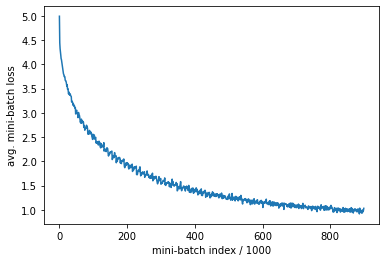

In [7]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

## Evaluate Test Data

In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 46 %


## Evaluate Test Set Across Classes

In [9]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(100):
    print('Accuracy of {i} : %2d %%' % (100 * class_correct[i] / class_total[i]))

Accuracy of {i} : 80 %
Accuracy of {i} : 60 %
Accuracy of {i} : 37 %
Accuracy of {i} : 25 %
Accuracy of {i} : 38 %
Accuracy of {i} : 35 %
Accuracy of {i} : 51 %
Accuracy of {i} : 44 %
Accuracy of {i} : 57 %
Accuracy of {i} : 53 %
Accuracy of {i} : 22 %
Accuracy of {i} : 33 %
Accuracy of {i} : 43 %
Accuracy of {i} : 39 %
Accuracy of {i} : 40 %
Accuracy of {i} : 39 %
Accuracy of {i} : 52 %
Accuracy of {i} : 42 %
Accuracy of {i} : 32 %
Accuracy of {i} : 38 %
Accuracy of {i} : 58 %
Accuracy of {i} : 77 %
Accuracy of {i} : 54 %
Accuracy of {i} : 53 %
Accuracy of {i} : 74 %
Accuracy of {i} : 36 %
Accuracy of {i} : 36 %
Accuracy of {i} : 34 %
Accuracy of {i} : 54 %
Accuracy of {i} : 41 %
Accuracy of {i} : 45 %
Accuracy of {i} : 43 %
Accuracy of {i} : 33 %
Accuracy of {i} : 38 %
Accuracy of {i} : 46 %
Accuracy of {i} : 18 %
Accuracy of {i} : 52 %
Accuracy of {i} : 42 %
Accuracy of {i} : 28 %
Accuracy of {i} : 62 %
Accuracy of {i} : 46 %
Accuracy of {i} : 63 %
Accuracy of {i} : 38 %
Accuracy of